# Mixplot analysis

In [1]:
import os
from scipy import io, sparse
from scipy.io import mmread
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
import numpy as np
def load_matrix(prefix=None):
    mtx = mmread(os.path.join(prefix,'matrix.mtx')).T
    mtx = mtx.tocsr()
    var = pd.read_csv(os.path.join(prefix,'features.tsv'), sep='\t', header=None, index_col=0)
    obs = pd.read_csv(os.path.join(prefix,'barcodes.tsv'), sep='\t', header=None, index_col=0)
    adata = sc.AnnData(X=mtx, var=var, obs=obs)
    return adata

In [2]:
# load data
cells = [i.strip() for i in open('./00_Preprocess/IL10/ATAC/merged/barcodes.tsv')]
hs_atac = pd.read_csv('./00_Preprocess/IL10/ATAC/fra_human.tsv',
                      header=None, names=['cb', 'count_hs'], index_col = 'cb', sep='\t')
mm_atac = pd.read_csv('./00_Preprocess/IL10/ATAC/fra_mouse.tsv',
                      header=None, names=['cb', 'count_mm'], index_col = 'cb', sep='\t')
df_atac = pd.concat([hs_atac, mm_atac], axis=1)
df_atac = df_atac.loc[cells,]
df_atac['total'] = df_atac['count_hs'] + df_atac['count_mm']

In [3]:
cells = [i.strip() for i in open('./00_Preprocess/IL10/RNA/merged/barcodes.tsv')]
hs_rna = pd.read_csv('./00_Preprocess/IL10/RNA/fra_human.tsv',
                     header=None, names=['cb', 'count_hs'], index_col='cb', sep='\t')
mm_rna = pd.read_csv('./00_Preprocess/IL10/RNA/fra_mouse.tsv',
                     header=None, names=['cb', 'count_mm'], index_col='cb', sep='\t')
df_rna = pd.concat([hs_rna, mm_rna], axis=1)
df_rna = df_rna.loc[cells,]
df_rna['total'] = df_rna['count_hs'] + df_rna['count_mm']

In [4]:
df_atac['species'] = 0
df_atac.loc[df_atac['count_hs']/df_atac['total'] > 0.8, 'species'] = 'Human'
df_atac.loc[df_atac['count_mm']/df_atac['total'] > 0.8, 'species'] = 'Mouse'
df_atac.replace({'species' : {0 : 'Mix'}}, inplace=True)

In [5]:
df_rna['species'] = 0
df_rna.loc[df_rna['count_hs']/df_rna['total'] > 0.8, 'species'] = 'Human'
df_rna.loc[df_rna['count_mm']/df_rna['total'] > 0.8, 'species'] = 'Mouse'
df_rna.replace({'species' : {0 : 'Mix'}}, inplace=True)

In [6]:
df_atac['species'].value_counts()

species
Mouse    1777
Human    1406
Mix        30
Name: count, dtype: int64

In [7]:
df_rna['species'].value_counts()

species
Mouse    1775
Human    1406
Mix        33
Name: count, dtype: int64

In [8]:
df_joint = pd.merge(df_atac, df_rna, how = 'inner', left_index = True, right_index = True, suffixes = ('_atac', '_rna'))
df_joint.head()

,count_hs_atac,count_mm_atac,total_atac,species_atac,count_hs_rna,count_mm_rna,total_rna,species_rna
cb,,,,,,,,
BC0001_N02,1231,240351,241582,Mouse,5598,262017,267615,Mouse
BC0002_N02,325,143820,144145,Mouse,1254,51364,52618,Mouse
BC0003_N01,88099,255,88354,Human,102048,1879,103927,Human
BC0004_N01,70226,214,70440,Human,6028,214,6242,Human
BC0005_N01,178,63724,63902,Mouse,4418,191285,195703,Mouse


In [9]:
df_joint['ATAC GRCh38 fragments %'] = df_joint['count_hs_atac']/df_joint['total_atac'] * 100
df_joint['RNA GRCh38 reads %'] = df_joint['count_hs_rna']/df_joint['total_rna'] * 100

In [10]:
df_joint['species_atac'].value_counts()

species_atac
Mouse    1777
Human    1406
Mix        30
Name: count, dtype: int64

In [11]:
df_joint['species_rna'].value_counts()

species_rna
Mouse    1775
Human    1405
Mix        33
Name: count, dtype: int64

In [12]:
df_joint['species_joint'] = df_joint['species_atac'] + df_joint['species_rna']
df_joint['species_joint'].value_counts()

species_joint
MouseMouse    1773
HumanHuman    1403
MixMix          26
MouseMix         4
HumanMix         3
MixHuman         2
MixMouse         2
Name: count, dtype: int64

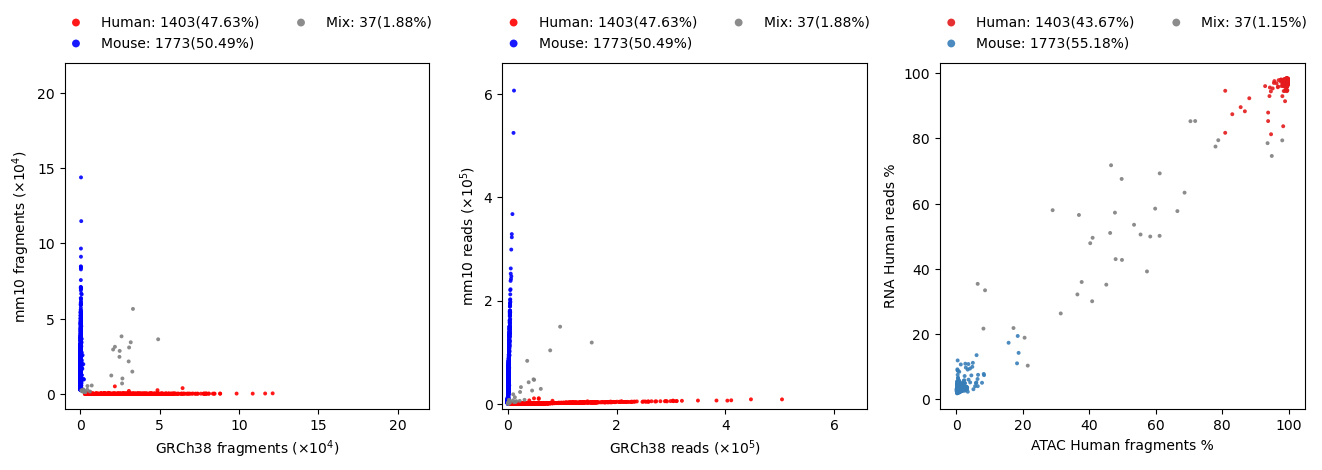

In [13]:
import matplotlib.pyplot as plt 
import numpy as np 
plt.rcParams['figure.figsize'] = (16, 4.5)
fig, ax = plt.subplots(1,3)
# atac
plt.subplot(1,3,1)
for sp, c in zip(['Human', 'Mouse', 'Mix'], ["red", "blue", "grey"]):
    plt.scatter(df_joint.query('species_atac == @sp')['count_hs_atac'], df_joint.query('species_atac == @sp')['count_mm_atac'],
                c=c, ec=None, s=8, label=f'{sp}: {df_joint.species_joint.value_counts()[sp]}({ratio[sp]}%)', alpha=.9)
plt.xlim(-10000, 220000)
plt.ylim(-10000, 220000)
plt.xticks([0, 50000, 100000, 150000, 200000], ['0', '5', '10', '15', '20'])
plt.yticks([0, 50000, 100000, 150000, 200000], ['0', '5', '10', '15', '20'])
plt.xlabel(r'GRCh38 fragments ($\times 10^4$)')
plt.ylabel(r'mm10 fragments ($\times 10^4$)')
plt.legend(frameon=False, markerscale=2,loc=8,bbox_to_anchor=(0.5, 1.0),ncol=2)

# rna
plt.subplot(1,3,2)
for sp, c in zip(['Human', 'Mouse', 'Mix'], ["red", "blue", "grey"]):
    plt.scatter(df_joint.query('species_rna == @sp')['count_hs_rna'], df_joint.query('species_rna == @sp')['count_mm_rna'],
                c=c, ec=None, s=8, label=f'{sp}: {df_joint.species_joint.value_counts()[sp]}({ratio[sp]}%)', alpha=.9)
plt.xlim(-10000, 660000)
plt.ylim(-10000, 660000)
plt.xticks([0, 200000, 400000, 600000], ['0', '2', '4', '6'])
plt.yticks([0, 200000, 400000, 600000], ['0', '2', '4', '6'])
plt.xlabel(r'GRCh38 reads ($\times 10^5$)')
plt.ylabel(r'mm10 reads ($\times 10^5$)')
plt.legend(frameon=False, markerscale=2,loc=8,bbox_to_anchor=(0.5, 1.0),ncol=2)

# atac/rna
plt.subplot(1,3,3)
ratio = round(df_joint.species_joint.value_counts() / sum(df_joint.species_joint.value_counts()) * 100, 2)
for sp, c in zip(['Human', 'Mouse', 'Mix'], ["#E41A1C", "#377EB8", "grey"]):
    plt.scatter(df_joint.query('species_joint == @sp')['ATAC GRCh38 fragments %'],
                df_joint.query('species_joint == @sp')['RNA GRCh38 reads %'], ec=None,
                c=c, s=8, label=f'{sp}: {df_joint.species_joint.value_counts()[sp]}({ratio[sp]}%)', alpha=.9)
plt.legend(frameon=False, markerscale=2,loc=8,bbox_to_anchor=(0.5, 1.0),ncol=2)
plt.xlabel(r'ATAC Human fragments %')
plt.ylabel(r'RNA Human reads %')

plt.savefig('./01_Celline/mixplot.pdf', bbox_inches='tight', transparent=True, dpi=600)
plt.show()